In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision
%matplotlib inline
plt.ion()

In [3]:
import zipfile
with zipfile.ZipFile('/home/jupyter/datasphere/project/lung.zip', 'r') as zipref:
    zipref.extractall('/home/jupyter/datasphere/project/dataset')

In [5]:
classes = ("lung_aca", "lung_n", "lung_scc")

def image_shower(images, labels, n=3):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = images / 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        print("Real Labels: ", ' '.join('%5s' %  classes[label] for label in labels[:n]))
PATH="/home/jupyter/datasphere/project/dataset"

In [6]:
import os
import random
from torch.utils.data import DataLoader, Subset

# Преобразования для изображений
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Загружаем датасет (ImageFolder ожидает, что папки организованы по классам)
full_dataset = datasets.ImageFolder(PATH, transform=data_transforms)

# Получаем индексы всех изображений и распределяем их по классам
class_to_indices = {class_name: [] for class_name in full_dataset.classes}

# Наполняем class_to_indices (распределяем индексы по классам)
for idx, (_, class_idx) in enumerate(full_dataset.samples):
    class_name = full_dataset.classes[class_idx]
    class_to_indices[class_name].append(idx)

# Проверка: убедимся, что в каждом классе достаточно изображений
for class_name, indices in class_to_indices.items():
    if len(indices) != 5000:
        raise ValueError(f"В классе '{class_name}' количество изображений не равно 5000.")

# Формируем тренировочные и тестовые индексы для каждого класса
train_indices = []
test_indices = []

for class_name, indices in class_to_indices.items():
    # Перемешиваем индексы для случайного разделения
    random.shuffle(indices)
    # Берем первые 4000 для тренировки и следующие 1000 для теста
    train_indices.extend(indices[:4000])
    test_indices.extend(indices[4000:4000 + 1000])

# Создаем тренировочные и тестовые датасеты
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Создаем DataLoader для обучения и тестирования
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

# Классы
classes = full_dataset.classes

print('Classes:', classes)
print('Train set size:', len(train_dataset))  # 12000
print('Test set size:', len(test_dataset))  # 3000

Classes: ['lung_aca', 'lung_n', 'lung_scc']
Train set size: 12000
Test set size: 3000


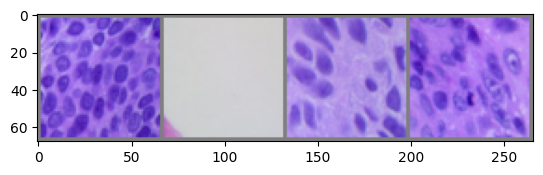

lung_scc lung_n lung_scc lung_scc


In [7]:
def imshow(img):
    img = img / 2 + 0.5  # Denormalize the image
    np_img = img.numpy()  # Convert the tensor to numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Transpose for proper display
    plt.show()

# Get a batch of images and labels
dataiter = iter(train_loader)  # Use the train_loader instead of train_dataset
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))

# Print the class names of the images in the batch
print(' '.join([classes[labels[j]] for j in range(len(labels))]))


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #сверточный фильтр, выделять яркие моменты
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2) #оставить только важное
        self.fc1 = nn.Linear(16 * 13 * 13, 120) #полносвязный слой
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #функция активации нейронов
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [9]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация по батчу
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout = nn.Dropout(0.5)  # Отсев для регуляризации
        self.fc2 = nn.Linear(256, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка → BatchNorm → ReLU → Пуллинг
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))  # Полносвязный слой → ReLU
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)  # Выходной слой
        return x

deepcnn = DeepCNN()
print(deepcnn)

DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [10]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnnwithdropout = CNNWithDropout()
print(cnnwithdropout)

CNNWithDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizerNet = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizerDeepCNN = optim.SGD(deepcnn.parameters(), lr=0.001, momentum=0.9)
optimizerDropout = optim.SGD(cnnwithdropout.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu") # Replace "cpu" with "cuda" if using GPU

In [12]:
def train_model(net, trainloader, optimizer, criterion, device):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(trainloader)

def evaluate_model(net, testloader, criterion, device):
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(testloader), accuracy


In [ ]:
for epoch in range(10):
    train_loss_net = train_model(net, train_loader, optimizerNet, criterion, device)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:  # Выполнять каждые 5 эпох или на первой эпохе
        test_loss_net, test_accuracy_net = evaluate_model(net, test_loader, criterion, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_net:.4f}, Test Loss: {test_loss_net:.4f}, Accuracy: {test_accuracy_net:.2f}%")
    else:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_net:.4f}")

Epoch 1, Train Loss: 1.5193, Test Loss: 0.3993, Accuracy: 84.67%
Epoch 2, Train Loss: 0.3251
Epoch 3, Train Loss: 0.2936
Epoch 4, Train Loss: 0.2635
Epoch 5, Train Loss: 0.2440, Test Loss: 0.2469, Accuracy: 89.97%
Epoch 6, Train Loss: 0.2340
Epoch 7, Train Loss: 0.2266
Epoch 8, Train Loss: 0.2163
Epoch 9, Train Loss: 0.2259
Epoch 10, Train Loss: 0.2242, Test Loss: 0.2040, Accuracy: 92.50%


In [44]:
for epoch in range(10):
    train_loss_deep = train_model(deepcnn, train_loader, optimizerDeepCNN, criterion, device)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:  # Выполнять каждые 5 эпох или на первой эпохе
        test_loss_deep, test_accuracy_deep = evaluate_model(deepcnn, test_loader, criterion, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_deep:.4f}, Test Loss: {test_loss_deep:.4f}, Accuracy: {test_accuracy_deep:.2f}%")
    else:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_deep:.4f}")

Epoch 1, Train Loss: 0.2225, Test Loss: 0.1971, Accuracy: 92.23%
Epoch 2, Train Loss: 0.2148
Epoch 3, Train Loss: 0.2153
Epoch 4, Train Loss: 0.2193
Epoch 5, Train Loss: 0.2023, Test Loss: 0.1595, Accuracy: 93.63%
Epoch 6, Train Loss: 0.2072
Epoch 7, Train Loss: 0.1962
Epoch 8, Train Loss: 0.1939
Epoch 9, Train Loss: 0.1856
Epoch 10, Train Loss: 0.1811, Test Loss: 0.1476, Accuracy: 94.13%


In [56]:
for epoch in range(10):
    train_loss_dropout = train_model(cnnwithdropout, train_loader, oprimizerDropout, criterion, device)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:  # Выполнять каждые 5 эпох или на первой эпохе
        test_loss_dropout, test_accuracy_dropout = evaluate_model(cnnwithdropout, test_loader, criterion, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_dropout:.4f}, Test Loss: {test_loss_dropout:.4f}, Accuracy: {test_accuracy_dropout:.2f}%")
    else:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_dropout:.4f}")

Epoch 1, Train Loss: 0.2418, Test Loss: 0.2184, Accuracy: 90.57%
Epoch 2, Train Loss: 0.2307
Epoch 3, Train Loss: 0.2259
Epoch 4, Train Loss: 0.2183
Epoch 5, Train Loss: 0.2101, Test Loss: 0.2399, Accuracy: 90.73%
Epoch 6, Train Loss: 0.2030
Epoch 7, Train Loss: 0.1966
Epoch 8, Train Loss: 0.1934
Epoch 9, Train Loss: 0.1901
Epoch 10, Train Loss: 0.1732, Test Loss: 0.1643, Accuracy: 93.67%


In [31]:
# Загружаем предобученную модель
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Изменяем последний слой для задачи
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(classes))
resnet = resnet.to(device)

# Оптимизатор
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

# Загружаем предобученную модель
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Изменяем последний слой
num_ftrs = mobilenet.last_channel
mobilenet.classifier[1] = nn.Linear(num_ftrs, len(classes))
mobilenet = mobilenet.to(device)

# Оптимизатор
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)

In [57]:
for epoch in range(10):
    train_loss_resnet = train_model(resnet, train_loader, optimizer_resnet, criterion, device)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:  # Выполнять каждые 5 эпох или на первой эпохе
        test_loss_resnet, test_accuracy_resnet = evaluate_model(resnet, test_loader, criterion, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_resnet:.4f}, Test Loss: {test_loss_resnet:.4f}, Accuracy: {test_accuracy_resnet:.2f}%")
    else:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_resnet:.4f}")

Epoch 1, Train Loss: 0.5279, Test Loss: 0.3055, Accuracy: 86.27%
Epoch 2, Train Loss: 0.3421
Epoch 3, Train Loss: 0.2843
Epoch 4, Train Loss: 0.2475
Epoch 5, Train Loss: 0.2108, Test Loss: 0.1982, Accuracy: 92.07%
Epoch 6, Train Loss: 0.2049
Epoch 7, Train Loss: 0.1907
Epoch 8, Train Loss: 0.1783
Epoch 9, Train Loss: 0.1665
Epoch 10, Train Loss: 0.1562, Test Loss: 0.1458, Accuracy: 94.53%


In [30]:
for epoch in range(10):
    train_loss_mobilenet = train_model(mobilenet, train_loader, optimizer_mobilenet, criterion, device)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:  # Выполнять каждые 5 эпох или на первой эпохе
        test_loss_mobilenet, test_accuracy_mobilenet = evaluate_model(mobilenet, test_loader, criterion, device)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_mobilenet:.4f}, Test Loss: {test_loss_mobilenet:.4f}, Accuracy: {test_accuracy_mobilenet:.2f}%")
    else:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_mobilenet:.4f}")

Epoch 10, Train Loss: 0.1945, Test Loss: 0.1963, Accuracy: 93.77%
